# Projet Optimisation
---

In [14]:
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize) # To print more elements of an array in terminal
import pandas as pd
from scipy.optimize import linprog
import matplotlib.pyplot as plt

## Question 1.B
Dans cette section, nous implémentons et résolvons le première modèle de la question 1) à savoir :
$$
\begin{align*}
    \max_{c_i} \quad  
    &\gamma \\ 
    \sum_{i=0}^{n-1} c_i &= P\\
    \sum_{\text{\tiny offshore}}c_i &= \kappa P\\
    \gamma &\le \sum_{i=0}^{n-1} c_i e_i(t_j) \quad \forall j \in \{0, \ldots, m-1\}\\
    0 &\le \, c_i \, \le c_i^{\max} \quad \forall i \in \{0, \ldots, n-1\}
\end{align*}
$$

---

## Paramètres

In [2]:
# Problem parameters
P = 500_000
k = 0.17

## Lecture des données dans les `.csv`

In [4]:
# Loads dataframe
sites_df = pd.read_csv('Data-partie-1/Sites.csv')
offshore_df = pd.read_csv('Data-partie-1/Rendements_offshore.csv', header=None).to_numpy()
onshore_df = pd.read_csv('Data-partie-1/Rendements_onshore.csv', header=None).to_numpy()

# Get index of onshore and offshore sites and convert to numpy array
offshore_idx = sites_df[sites_df['capacite offshore'] == 'Oui']['index site'].to_numpy(dtype=int)
onshore_idx = sites_df[sites_df['capacite offshore'] == 'Non']['index site'].to_numpy(dtype=int)

# Filter offshore and onshore dataframes
offshore_df = offshore_df[offshore_idx, :]
onshore_df = onshore_df[onshore_idx, :]

## Création du modèle

In [5]:
# Get number of sites (n) and number of hours in a year (m)
n = sites_df.shape[0]
m = offshore_df.shape[1]

# Create A_eq matrix
A_eq = np.zeros((2, n+1))
A_eq[0, :-1] = np.ones(n)
A_eq[1, offshore_idx] = 1

# Create b_eq matrix
b_eq = np.zeros(2)
b_eq[0] = P
b_eq[1] = k*P

# Create A_ub matrix
A_ub = np.zeros((m, n+1))
A_ub[:, -1] = np.ones(m)
A_ub[:, offshore_idx] = -offshore_df.T
A_ub[:, onshore_idx] = -onshore_df.T

# Create b_ub matrix
b_ub = np.zeros(m)

# Create bounds for c_i
bounds = [(0, None) for i in range(n+1)]
bounds[-1] = (None, None)
for i in offshore_idx:
    bounds[i] = (0, sites_df.iloc[i]['capacites'])
for i in onshore_idx:
    bounds[i] = (0, sites_df.iloc[i]['capacites'])

# Create variable array
objective_function = np.zeros(n+1)
objective_function[-1] = -1

## Résolution du problème

In [29]:
# Solve linear program
sol = linprog(c=objective_function, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=bounds)
print(sol.x)
np.save('Data-partie-1/solution.npy', sol.x)

[7.50960700e+03 5.00370963e+03 4.22578159e+03 4.22578159e+03
 5.00370963e+03 5.45941686e+03 5.45941686e+03 4.98522427e+03
 4.19058680e+03 3.55377158e+03 3.29525404e+03 3.51351480e+03
 3.60187187e+03 3.60187187e+03 3.60187187e+03 3.50947554e+03
 3.28308503e+03 3.01243533e+03 0.00000000e+00 0.00000000e+00
 2.82405729e+03 2.82405729e+03 3.01983832e+03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.30203727e+03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.67198350e+03
 1.13158474e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.35783523e+03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.05344254e+02 2.12711390e+03 1.89348346e+03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.34194087e+03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

## Calcul de l'énergie totale produite

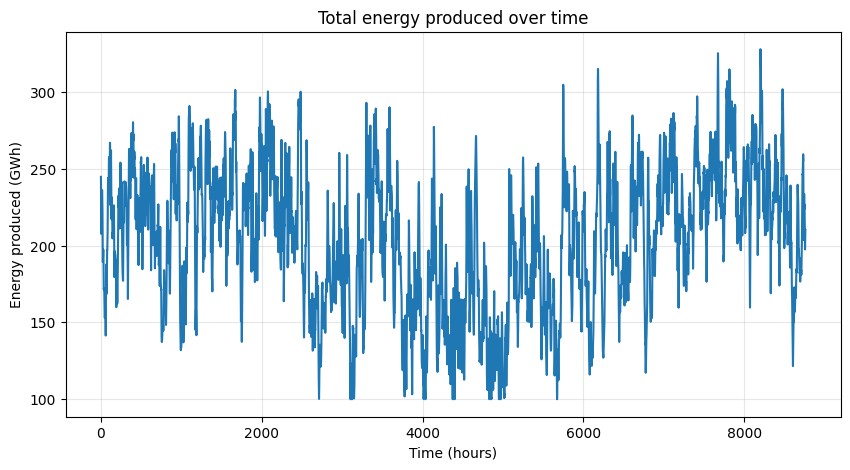

In [33]:
# Load solution
sol = np.load('Data-partie-1/solution.npy')

# Compute total energy produced
energy_produced = np.zeros(m)
for i in range(m):
    energy_produced[i] += sol[offshore_idx]@offshore_df[:, i]
    energy_produced[i] += sol[onshore_idx]@onshore_df[:, i]

# Plot total energy produced over time
t = np.arange(1, m+1)
fig = plt.figure(figsize=(10, 5))
plt.title('Total energy produced over time')
plt.plot(t, energy_produced/1e3)
plt.xlabel('Time (hours)')
plt.ylabel('Energy produced (GWh)')
plt.grid(alpha=0.3)
plt.show()